In [1]:
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [24]:
tf.keras.backend.set_image_data_format('channels_last')

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = x_train / 255.
x_test = x_test / 255.

# Define the labels for the binary classification
def convert_to_binary_class(y):
    # Classes 0 (airplane) and 2 (bird) can fly, all others cannot
    return np.where(np.isin(y, [0, 2]), 1, 0)

y_train_binary = convert_to_binary_class(y_train)
y_test_binary = convert_to_binary_class(y_test)

print(x_train.shape, y_train_binary.shape, x_test.shape, y_test_binary.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [3]:
# Print to verify
print(y_train[:10])  # Original labels
print(y_train_binary[:10])  # Binary labels

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]]


In [4]:
# Define class names
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Define binary labels for whether each class can fly or not
fly_label = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

# Create a DataFrame
category = pd.DataFrame({
    'Category': label_names,
    'Can Fly (1) / Cannot Fly (0)': fly_label
})

# Display the DataFrame
print(category)


     Category  Can Fly (1) / Cannot Fly (0)
0    airplane                             1
1  automobile                             0
2        bird                             1
3         cat                             0
4        deer                             0
5         dog                             0
6        frog                             0
7       horse                             0
8        ship                             0
9       truck                             0


Images of objects that can fly:


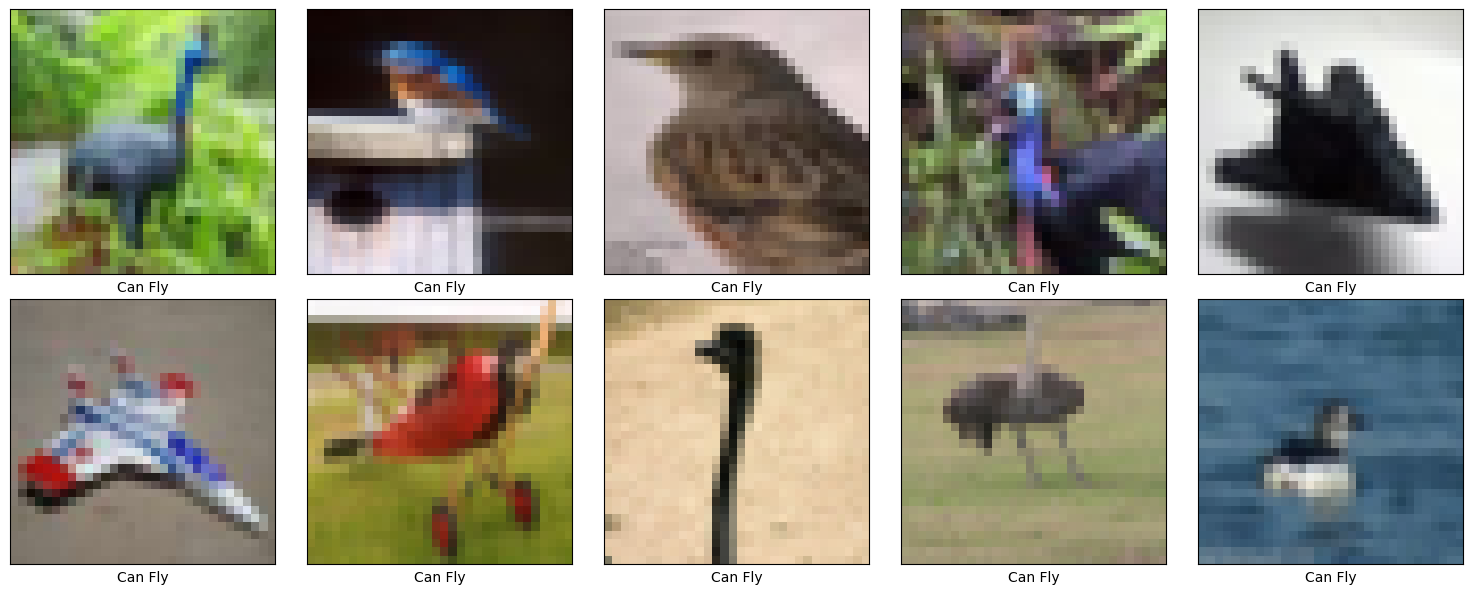

Images of objects that cannot fly:


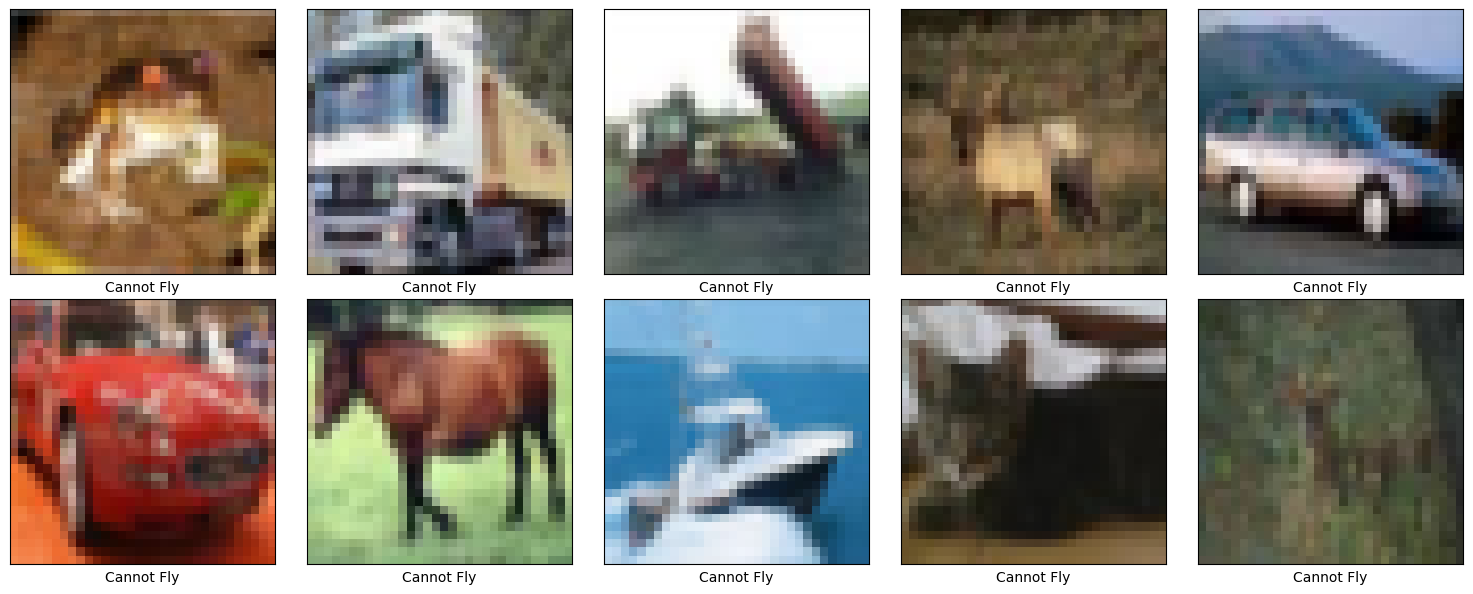

In [25]:
# Function to plot images by category
def plot_images_by_category(images, labels, binary_labels, category, num_rows=2, num_cols=5):
    plt.figure(figsize=(15, 6))
    indices = np.where(binary_labels == category)[0]
    for i in range(min(num_rows * num_cols, len(indices))):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[indices[i]], interpolation='nearest')
        plt.xlabel('Can Fly' if category == 1 else 'Cannot Fly')
    plt.tight_layout()
    plt.show()

# Plot images for the 'can fly' category
print("Images of objects that can fly:")
plot_images_by_category(x_train, y_train, y_train_binary, category=1)

# Plot images for the 'cannot fly' category
print("Images of objects that cannot fly:")
plot_images_by_category(x_train, y_train, y_train_binary, category=0)

In [26]:
# Fit a CNN having the following architecture:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=x_train[0].shape),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(52, kernel_size=(3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3)),
    tf.keras.layers.LeakyReLU(negative_slope=0.01),  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('sigmoid')
])

model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.005), 
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 30, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 52)     │         7,540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 13, 13, 52)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 13, 13, 52)     │           208 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 52)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 52)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 32)       │        15,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,973 (124.89 KB)

 Trainable params: 31,645 (123.61 KB)

 Non-trainable params: 328 (1.28 KB)

None


### What is Leaky ReLU:
The Leaky ReLU activation function is a variation of the Rectified Linear Unit (ReLU) activation function. Similar to ReLU, it applies a thresholding operation to the input values, setting negative values to zero.


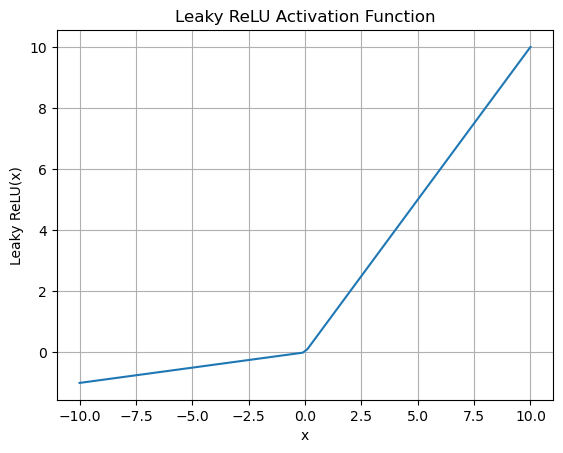

In [7]:
# Exemple of LeakyRelu
def plot_leaky_relu():
    # Generate values for x
    x = np.linspace(-10, 10, 100)

    # Define the leaky ReLU function
    def leaky_relu(x, alpha=0.1):
        return np.where(x >= 0, x, alpha * x)

    # Compute leaky ReLU values for corresponding x
    leaky_relu_values = leaky_relu(x)

    # Plot the leaky ReLU function
    plt.plot(x, leaky_relu_values)
    plt.title("Leaky ReLU Activation Function")
    plt.xlabel("x")
    plt.ylabel("Leaky ReLU(x)")
    plt.grid(True)
    plt.show()
    
plot_leaky_relu()

In [27]:
history = model.fit(x_train, y_train_binary, epochs=100, batch_size=32, validation_split=0.15)

Epoch 1/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7618 - loss: 0.5117 - val_accuracy: 0.8215 - val_loss: 0.4474
Epoch 2/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8251 - loss: 0.4072 - val_accuracy: 0.8303 - val_loss: 0.4104
Epoch 3/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8361 - loss: 0.3826 - val_accuracy: 0.8431 - val_loss: 0.3718
Epoch 4/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8465 - loss: 0.3631 - val_accuracy: 0.8223 - val_loss: 0.4023
Epoch 5/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8533 - loss: 0.3499 - val_accuracy: 0.8593 - val_loss: 0.3413
Epoch 6/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8595 - loss: 0.3397 - val_accuracy: 0.8591 - val_loss: 0.3449
Epoch 7/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8593 - loss: 0.3376 - val_accuracy: 0.8821 - val_loss: 0.3014
Epoch 8/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.867

Epoch 50/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8887 - loss: 0.2727 - val_accuracy: 0.8959 - val_loss: 0.2568
Epoch 51/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8937 - loss: 0.2638 - val_accuracy: 0.9033 - val_loss: 0.2500
Epoch 52/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8930 - loss: 0.2633 - val_accuracy: 0.8943 - val_loss: 0.2697
Epoch 53/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.8921 - loss: 0.2668 - val_accuracy: 0.8964 - val_loss: 0.2608
Epoch 54/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.8914 - loss: 0.2693 - val_accuracy: 0.9019 - val_loss: 0.2498
Epoch 55/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.8934 - loss: 0.2657 - val_accuracy: 0.9080 - val_loss: 0.2396
Epoch 56/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8957 - loss: 0.2624 - val_accuracy: 0.9089 - val_loss: 0.2362
Epoch 57/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - ac

Epoch 99/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.8984 - loss: 0.2514 - val_accuracy: 0.9121 - val_loss: 0.2275
Epoch 100/100
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8991 - loss: 0.2482 - val_accuracy: 0.9144 - val_loss: 0.2347


In [29]:
model.evaluate(x_test, y_test_binary)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9014 - loss: 0.2513


[0.2499794214963913, 0.9031999707221985]

In [33]:
# Make predictions on the test set
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Compute accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print classification report
print(classification_report(y_test_binary, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9032
Precision: 0.8325
Recall: 0.6460
F1 Score: 0.7275
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      8000
           1       0.83      0.65      0.73      2000

    accuracy                           0.90     10000
   macro avg       0.87      0.81      0.83     10000
weighted avg       0.90      0.90      0.90     10000



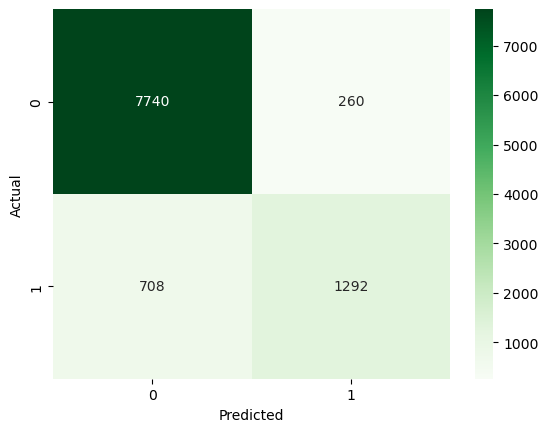

In [39]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Plot training & validation accuracy values

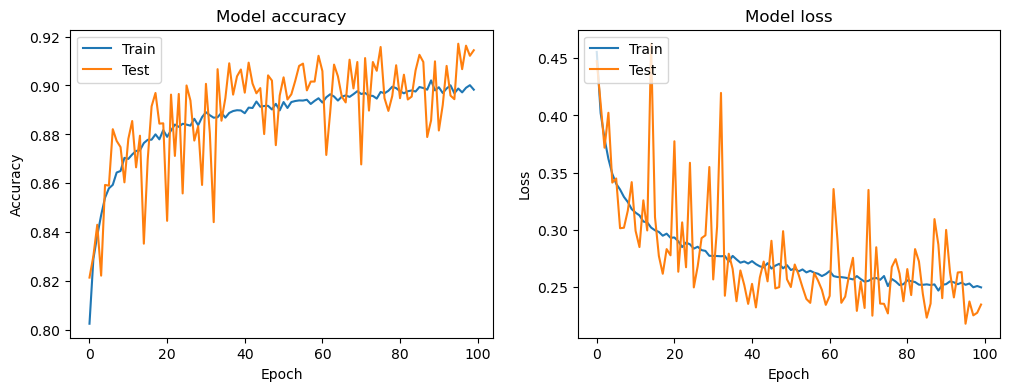

In [35]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

## Test with a new Image

In [36]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype(np.float32) / 255.0
    return img_array

def predict_image_class(model, img_array):
    prediction = model.predict(img_array)
    if prediction > 0.5:
        return "Can Fly"
    else:
        return "Cannot Fly"

# Load and preprocess the new image
img_path = 'bird.jpg'  
img_array = load_and_preprocess_image(img_path)

# Predict the class of the new image
prediction = predict_image_class(model, img_array)
print("The object in the image:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The object in the image: Can Fly


In [40]:
# Load and preprocess the new image
img_path = 'car.jpg'  
img_array = load_and_preprocess_image(img_path)

# Predict the class of the new image
prediction = predict_image_class(model, img_array)
print("The object in the image:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The object in the image: Cannot Fly
